In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_json("../data/raw/210119_en_deter_preprocessed.json")
phrases = pd.read_csv("../data/raw/noun-phrases-without-adv.csv", converters={"np": eval})

In [3]:
train = pd.merge(
    dataset,
    phrases.loc[:, ["doc_id", "np"]],
    how="left",
    on="doc_id"
)

In [4]:
# subset that we're training
df = train.loc[train["np"].notnull()].copy()

In [5]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

In [6]:
# distribution starting from 1990
df.loc[df["year"] >= 1990, "year"].value_counts()

2010.0    637
2017.0    587
2009.0    541
2016.0    476
2018.0    425
2011.0    385
2019.0    311
2015.0    300
2013.0    285
2020.0    267
2012.0    251
2008.0    224
2014.0    199
2001.0    170
2002.0    168
1999.0    162
1998.0    162
2000.0    159
2006.0    157
2007.0    147
2003.0    129
1997.0    116
2004.0    105
1996.0    104
2005.0    103
1995.0     97
1993.0     56
1994.0     55
1991.0     51
1990.0     50
1992.0     43
Name: year, dtype: int64

In [7]:
# preparing data for visualization
dist = (
    df["year"]
     .value_counts()
     .to_frame()
     .reset_index()
     .rename(columns={"year": "counts", "index": "year"})
)

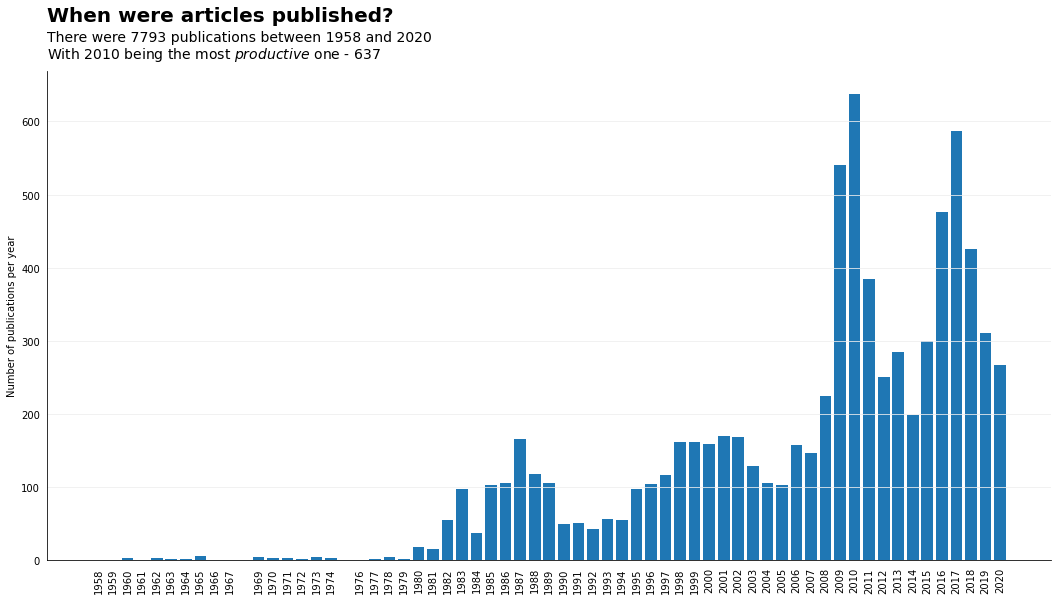

In [8]:
# first viz
fig, ax = plt.subplots(1, 1, figsize=(18,9))

# removing 1900 outlier
dist = dist.loc[dist["year"] > 1900]
ax.bar(dist["year"], dist["counts"], label="counts", tick_label=dist["year"].astype(int))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.yaxis.grid(True, color='#EEEEEE')

plt.ylabel("Number of publications per year")
plt.xticks(rotation=90)

fig.suptitle("When were articles published?", fontsize=20, fontweight='bold',x=0.125,ha='left')
fig.text(0.125,0.927,f"There were {dist['counts'].sum()} publications between {dist['year'].astype(int).min()} and {dist['year'].astype(int).max()}",fontsize=14)
fig.text(0.125,0.9,f"With {dist.iloc[0, 0].astype(int)} being the most $productive$ one - {dist.iloc[0, 1].astype(int)}",fontsize=14)
plt.savefig("../reports/figures/1.0-training subset total.png", dpi=300, bbox_inches="tight", pad_inches=0.3, transparent=False)
plt.show()

In [9]:
# the same but for publications with full text available
has_text = df.loc[~(df["fulltext"].isna() | df["fulltext"].eq("") | (df["fulltext"].str.contains("^Not available.")))]

has_text_dist = (
    has_text["year"]
     .value_counts()
     .to_frame()
     .reset_index()
     .rename(columns={"year": "counts", "index": "year"})
)

In [10]:
annotations = pd.merge(dist, has_text_dist, how="left", on="year", suffixes=("_all", "_fulltext"))
annotations["perc"] = (annotations["counts_fulltext"].fillna(0) / annotations["counts_all"] * 100).astype(int).astype(str) + "%"
annotations

,year,counts_all,counts_fulltext,perc
0,2010.0,637,637,100%
1,2017.0,587,587,100%
2,2009.0,541,541,100%
3,2016.0,476,476,100%
4,2018.0,425,425,100%
...,...,...,...,...
56,1958.0,1,1,100%
57,1976.0,1,1,100%
58,1961.0,1,1,100%
59,1966.0,1,1,100%


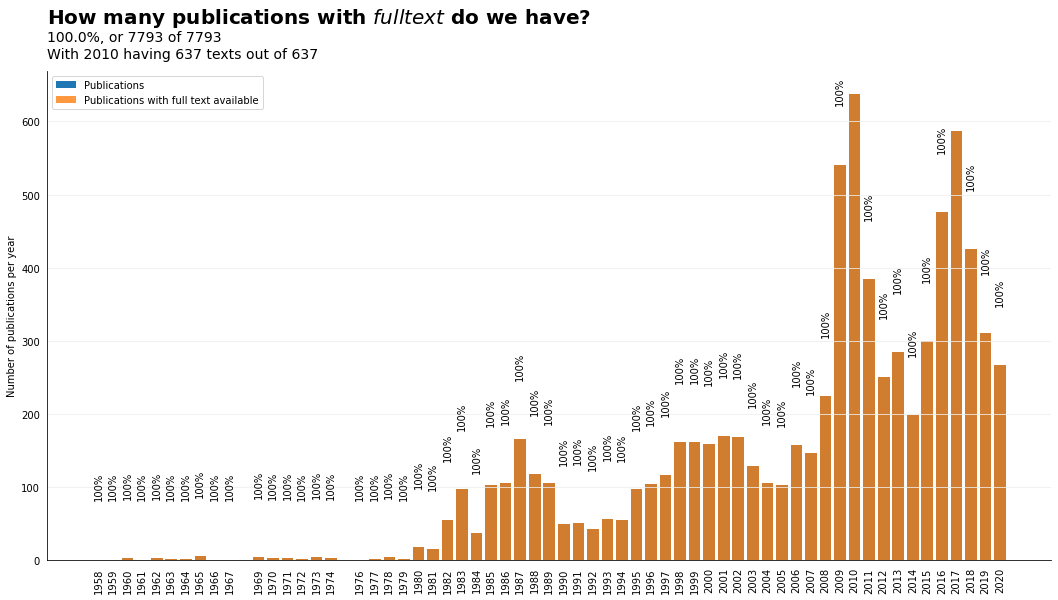

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(18,9))

# removing 1900 outlier
dist = dist.loc[dist["year"] > 1900]
ax.bar(dist["year"], dist["counts"], label="Publications", tick_label=dist["year"].astype(int))
ax.bar(has_text_dist["year"], has_text_dist["counts"], label="Publications with full text available", alpha=0.8)

for idx in annotations.index:
    _row = annotations.loc[idx, :]
    ax.annotate(
        _row["perc"],
        xy=(_row["year"], _row["counts_all"] + 100),
        ha="center", va="center", rotation=90
  )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.yaxis.grid(True, color='#EEEEEE')

plt.ylabel("Number of publications per year")
plt.xticks(rotation=90)
plt.legend()

fig.suptitle("How many publications with $fulltext$ do we have?", fontsize=20, fontweight='bold',x=0.125,ha='left')
fig.text(0.125,0.927,f'{(has_text_dist["counts"].sum() / dist["counts"].sum() * 100).round(2)}%, or {has_text_dist["counts"].sum()} of {dist["counts"].sum()}',fontsize=14)
fig.text(0.125,0.9,f"With {dist.iloc[0, 0].astype(int)} having {has_text_dist.iloc[0, 1]} texts out of {dist.iloc[0, 1]}",fontsize=14)
plt.savefig("../reports/figures/1.0-training subset with fulltext.png", dpi=300, bbox_inches="tight", pad_inches=0.3, transparent=False)
plt.show()

In [16]:
df.to_csv("../data/raw/training-subset.csv", index=False)